# Parameters




Parameters are shown in papers linked below.

1. [Durstewitz et. al., 2000 ](https://papers.cnl.salk.edu/PDFs/Dopamine-Mediated%20Stabilization%20of%20Delay-Period%20Activity%20in%20a%20Network%20Model%20of%20Prefrontal%20Cortex%202000-3711.pdf)

2. [Durstewitz et. al., 2002](https://www.bio.psy.ruhr-uni-bochum.de/bpsy/mam/content/documents/durstewitz_2002_the_computational_role_of_dopamine_d1.pdf)

In [1]:
### Morphology ###

soma_l = 28.62
soma_d = 21.84

dend_l = 650
dend_d = 6.5

### Passive properties ###

soma_Rm = 30000     # membrane resistance
soma_Eleak = -70    # leakage reversal potential
soma_Cm = 1.2       # membrane capacitance
soma_Ri = 150       # axial resistance

dend_Rm = soma_Rm / 1.92
dend_Eleak = -70
dend_Cm = soma_Cm * 1.92 
dend_Ri = 150

### Ionic conductances ###

soma_INa = 0.117      # Na+ current
soma_INaP = 0.0018     # persistent Na+ current
soma_IDR = 0.005       # delayed rectifier current
soma_IKS = 8e-5 + 0.001     # slowly inactivating K+ current
soma_IC = 0.0021       # voltage-dependent C-type K+ current
soma_IHVA = 0.0004     # high-voltage-activated Ca2+ current

dend_INa = 0.02
dend_INaP = 0.0008
dend_IDR = 0.0014
dend_IKS = soma_IKS
dend_IC = soma_IC
dend_IHVA = 0.0008

CAF = 600e-9   # calcium accumulation factor

### Plasticity parameters ###

ampa_tau1 = 0.55  # ms
ampa_tau2 = 2.2   # ms

nmda_taus = 0.1
nmda_tau1 = 10.6   # ms
nmda_tau2 = 285.0  # ms

### Desired peak conductances

g_AMPA_max = 4e-9   # S/cm2
g_NMDA_max = g_AMPA_max / 50    # S/cm2

USE = 0.6       # STD utilization parameter 
t_rec = 800     # recovery time (ms)


# Import Libraries

In [2]:
from neuron import h
import numpy as np
import matplotlib.pyplot as plt

h.load_file('stdrun.hoc')

### load ionic conductances ###

h.nrn_load_dll("./mods/arm64/.libs/libnrnmech.so")
mechanisms = ['hh', 'naf', 'nap', 'hva', 'kdr', 'iks', 'ic', 'cadyn', 'kdyn']

# Generate Two-Compartment Model Neuron

In [3]:
### Create a soma ###

soma = h.Section(name='soma')

### Add morphology ###

soma.L = soma_l
soma.diam = soma_d

### Add passive properties ###

soma.insert('pas')
soma.g_pas = 1 / soma_Rm
soma.e_pas = soma_Eleak
soma.Ra = soma_Ri
soma.cm = soma_Cm

### Add ionic conductances ###

for i in mechanisms:
    soma.insert(i)

soma(0.5).nap.gnapbar = soma_INaP
soma(0.5).naf.gnafbar = soma_INa
soma(0.5).hva.ghvabar = soma_IHVA
soma(0.5).kdr.gkdrbar = soma_IDR
soma(0.5).iks.gKsbar = soma_IKS
soma(0.5).ic.gkcbar = soma_IC
soma(0.5).cadyn.CAF = CAF

In [4]:
### Create a dendrite ###

dend = h.Section(name='dend')

### Add morphology ###

dend.L = dend_l
dend.diam = dend_d

### Add passive properties ###

dend.insert('pas')  # Passive dendrite
dend.g_pas = 1 / dend_Rm
dend.e_pas = dend_Eleak
dend.Ra = dend_Ri
dend.cm = dend_Cm

# Add ionic conductances

for i in mechanisms:
    dend.insert(i)

dend(0.5).nap.gnapbar = dend_INaP
dend(0.5).naf.gnafbar = dend_INa
dend(0.5).hva.ghvabar = dend_IHVA
dend(0.5).kdr.gkdrbar = dend_IDR
dend(0.5).iks.gKsbar = dend_IKS
dend(0.5).ic.gkcbar = dend_IC
dend(0.5).cadyn.CAF = CAF

### Connect soma and dendrite ###
dend.connect(soma)

dend

In [5]:
h.topology()


|-|       soma(0-1)
   `|       dend(0-1)



1.0

# Create Synapses

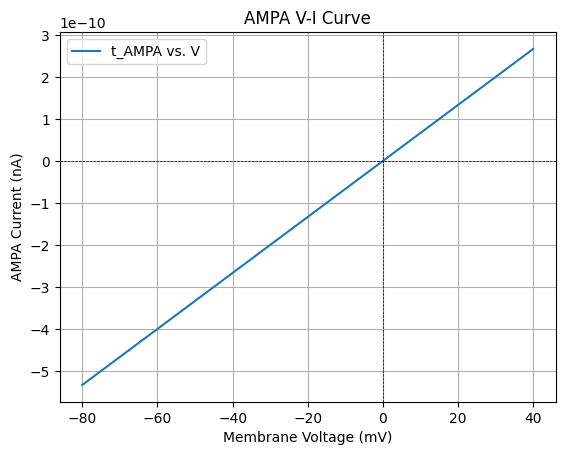

In [ ]:
from neuron import h

class Synapse:
    def __init__(self, sec, weight=1.0):
        
        # Create AMPA synapse
        self.ampa = h.Exp2Syn(sec(0.5))
        self.ampa.tau1 = 0.2  # AMPA time constant 1 (ms)
        self.ampa.tau2 = 1.0  # AMPA time constant 2 (ms)
        self.ampa.e = 0.0  # AMPA reversal potential (mV)
        self.ampa_g_max = 4e-9
        
        # Create NMDA synapse
        self.nmda = h.Exp2Syn(sec(0.5))
        self.nmda.tau1 = 2.3  # NMDA time constant 1 (ms)
        self.nmda.tau2 = 95.0  # NMDA time constant 2 (ms)
        self.nmda.e = 0.0  # NMDA reversal potential (mV)
        self.nmda_g_max = 4e-9 / 50

        # Weight parameters
        self.ampa_weight = weight
        self.nmda_weight = 1.0  # Fixed efficacy for NMDA
        
        # Short-term depression parameters
        self.use = 0.6  # Utilization parameter
        self.t_rec = 800  # Recovery time constant (ms)
        self.residual_depression = 1.0  # Tracks depression state
        
        # Voltage-dependent NMDA gating from Mel (1993)
        self.tau_s = 0.1  # Time constant for Mg²⁺ block kinetics
        
    def nmda_gating(self, v):
        
        # voltage-dependent Mg2+ gating
        return 1.50265 / (1 + 0.33 * h.exp(-0.06 * v))
    
    def update_ampa(self, presynaptic_input):
        
        # Update AMPA conductance with plasticity and short-term depression
        self.residual_depression *= (1 - self.use)  # Apply depression
        self.ampa_g = self.ampa_g_max *  self.ampa_weight * presynaptic_input * self.residual_depression
    
    def update_nmda(self, presynaptic_input, v):
        
        # Update NMDA conductance with voltage-dependent gating and compute current
        mg_block = self.nmda_gating(v)
        self.nmda_g = self.nmda_weight * mg_block * presynaptic_input
        self.nmda_current = self.nmda_g_max * self.nmda_g * mg_block * (v - self.nmda.e)  # I_NMDA = g_NMDA * s(V) * (V - E_NMDA)
    
    def recover_depression(self, dt):
        """Recover synaptic depression over time."""
        self.residual_depression += (1.0 - self.residual_depression) * (dt / self.t_rec)
    
    def update(self, presynaptic_input, v, dt):
        """Update both AMPA and NMDA conductances, including short-term depression recovery."""
        self.update_ampa(presynaptic_input)
        self.update_nmda(presynaptic_input, v)
        self.recover_depression(dt)

# Example usage
syn = Synapse(dend)

# syn.update(2.0, -65, 1.0)  # Example presynaptic input of 1.0, Vm=-65 mV, timestep dt=1.0 ms
# print(f"NMDA Conductance: {syn.nmda_g}, NMDA Current: {syn.nmda_current}")

# Define voltage range from -80 mV to +40 mV
voltages = np.linspace(-80, 40, 100)  # 100 points between -80 and 40 mV
nmda_currents = []
ampa_currents = []

# Loop through voltage values and compute NMDA current
for v in voltages:
    syn.update(2.0, v, 1.0)  # Presynaptic input = 2.0, timestep dt = 1.0 ms
    nmda_currents.append(syn.nmda_current)

# Loop through voltage values and compute AMPA current
for v in voltages:
    syn.update(2.0, v, 1.0)  # Presynaptic input = 2.0, timestep dt = 1.0 ms
    i_ampa = syn.ampa_g * (v - syn.ampa.e)  # AMPA current calculation
    ampa_currents.append(i_ampa)

# Plot V-I curve
# plt.plot(voltages, nmda_currents, label="I_NMDA vs. V")
plt.plot(voltages, ampa_currents, label="t_AMPA vs. V")
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)  # Zero current reference
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)  # Zero voltage reference
plt.xlabel("Membrane Voltage (mV)")
plt.ylabel("AMPA Current (nA)")
plt.title("AMPA V-I Curve")
plt.legend()
plt.grid(True)
plt.show()

########################

# # Define simulation parameters
# T_max = 100  # Total simulation time (ms)
# dt = 1.0  # Time step (ms)
# time_points = np.arange(0, T_max, dt)  # Time vector
# ampa_conductances = []

# # Presynaptic input: A pulse at t=20ms, 40ms, 60ms
# presynaptic_inputs = np.zeros_like(time_points)
# presynaptic_inputs[20] = 1.0
# presynaptic_inputs[40] = 1.0
# presynaptic_inputs[60] = 1.0

# # Simulate over time
# for i, t in enumerate(time_points):
#     syn.update(presynaptic_inputs[i], -65, dt)  # Vm = -65 mV (resting potential)
#     ampa_conductances.append(syn.ampa_g)  # Store AMPA conductance

# # Plot AMPA conductance over time
# plt.figure(figsize=(6, 4))
# plt.plot(time_points, ampa_conductances, label="g_AMPA", color="red")
# plt.xlabel("Time (ms)")
# plt.ylabel("AMPA Conductance (µS)")
# plt.title("AMPA Conductance Over Time")
# plt.legend()
# plt.grid(True)
# plt.show()

In [7]:
# from neuron import h

# class Synapse:
#     def __init__(self, sec, weight=1.0):
        
#         # Create AMPA synapses
#         self.ampa = h.Exp2Syn(sec(0.5))
#         self.ampa.tau1 = 0.2  # AMPA time constant 1 (ms)
#         self.ampa.tau2 = 1.0  # AMPA time constant 2 (ms)
#         self.ampa.e = 0.0  # AMPA reversal potential (mV)
        
#         # Create NMDA synapses
#         # self.nmda = h.Exp2Syn(sec(0.5))
#         # self.nmda.tau1 = 2.3  # NMDA time constant 1 (ms)
#         # self.nmda.tau2 = 95.0  # NMDA time constant 2 (ms)
#         # self.nmda.e = 0.0  # NMDA reversal potential (mV)
#         # self.nmda_g_max = 4e-9 / 50

#         # Weight parameters
#         self.ampa_weight = weight
#         # self.nmda_weight = 1.0  # Fixed efficacy for NMDA
        
#         # Short-term depression parameters
#         self.use = 0.6  # Utilization parameter
#         self.t_rec = 800  # Recovery time constant (ms)
#         self.residual_depression = 1.0  # Tracks depression state
        
#         # Voltage-dependent NMDA gating from Mel (1993)
#         # self.tau_s = 0.1  # Time constant for Mg²⁺ block kinetics
        
#     # def nmda_gating(self, v):
            
#     #     # voltage-dependent Mg2+ gating
#     #     return 1.50265 / (1 + 0.33 * h.exp(-0.06 * v))
    
#     def update_ampa(self, presynaptic_input):
#         """Update AMPA conductance with plasticity and short-term depression."""
#         self.residual_depression *= (1 - self.use)  # Apply depression
#         self.ampa.g = self.ampa_weight * presynaptic_input * self.residual_depression
    
#     # def update_nmda(self, presynaptic_input, v):
#     #     """Update NMDA conductance with voltage-dependent gating and compute current."""
#     #     mg_block = self.nmda_gating(v)
#     #     self.nmda_g = self.nmda_weight * mg_block * presynaptic_input
#     #     self.nmda_current = self.nmda_g_max * self.nmda_g * mg_block * (v - self.nmda.e)  # I_NMDA = g_NMDA * s(V) * (V - E_NMDA)
    
#     def recover_depression(self, dt):
#         """Recover synaptic depression over time."""
#         self.residual_depression += (1.0 - self.residual_depression) * (dt / self.t_rec)
    
#     def update(self, presynaptic_input, v, dt):
#         """Update both AMPA and NMDA conductances, including short-term depression recovery."""
#         self.update_ampa(presynaptic_input)
#         # self.update_nmda(presynaptic_input, v)
#         self.recover_depression(dt)

# # Example usage
# syn = Synapse(soma)

# # syn.update(2.0, -65, 1.0)  # Example presynaptic input of 1.0, Vm=-65 mV, timestep dt=1.0 ms
# # print(f"NMDA Conductance: {syn.nmda_g}, NMDA Current: {syn.nmda_current}")

# # Define voltage range from -80 mV to +40 mV
# voltages = np.linspace(-80, 40, 100)  # 100 points between -80 and 40 mV
# ampa_currents = []

# # Loop through voltage values and compute NMDA current
# for v in voltages:
#     syn.update(2.0, v, 1.0)  # Presynaptic input = 2.0, timestep dt = 1.0 ms
#     nmda_currents.append(syn.ampa_current)

# # Plot V-I curve
# plt.figure(figsize=(6, 4))
# plt.plot(voltages, ampa_currents, label="I_NMDA vs. V")
# plt.axhline(0, color='black', linestyle='--', linewidth=0.5)  # Zero current reference
# plt.axvline(0, color='black', linestyle='--', linewidth=0.5)  # Zero voltage reference
# plt.xlabel("Membrane Voltage (mV)")
# plt.ylabel("NMDA Current (nA)")
# plt.title("NMDA V-I Curve")
# plt.legend()
# plt.grid(True)
# plt.show()